In [35]:
# Script only for checking diagnostics (ipm histograms, time tool ampl and fltpos histograms, adu histogram, ePix100 ROI check)

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import h5py
from pathlib import Path
from scipy.ndimage import rotate

import XSpect.XSpect_Diagnostics as dt
import psana as ps

print('-----------------')
print('Modules imported!')
print('-----------------')

-----------------
Modules imported!
-----------------


In [2]:
# run = 339
# exp = 'xcsc00121'

# keys=['epics/ccm_E','tt/ttCorr','epics/lxt_ttc', 'enc/lasDelay' , 'ipm4/sum','tt/AMPL','epix_2/ROI_0_area'] 
# names=['ccm','time_tool_correction','lxt_ttc'  ,'encoder','ipm', 'time_tool_ampl','epix']

run = 238
#exp = 'mfxl1033223'
exp = 'mfx101080524'
keys=['epics/ccm_E','tt/ttCorr','epics/lxt_ttc', 'enc/lasDelay' , 'ipm_dg1/sum','tt/AMPL','epix_1/ROI_0_area'] 
names=['ccm','time_tool_correction','lxt_ttc'  ,'encoder','ipm', 'time_tool_ampl','epix']
run = 238
d = dt.diagnostics(run, exp, keys, names)


Run 238 imported


In [3]:
d.h5.keys()

<KeysViewHDF5 ['Rayonix', 'Sums', 'UserDataCfg', 'damage', 'ebeam', 'epics', 'epix_1', 'epix_1_env', 'event_time', 'evr', 'feeBld', 'fiducials', 'ipm_dg1', 'ipm_dg2', 'lightStatus', 'scan']>

In [4]:
d.h5['epix_1'].keys()

<KeysViewHDF5 ['ROI_0_area', 'ROI_0_com', 'ROI_0_max', 'ROI_0_mean', 'ROI_0_sum', 'droplet_nDroplets', 'droplet_nDroplets_all', 'full_com', 'full_max', 'full_mean', 'full_sum', 'var_droplet_sparse', 'var_droplet_sparse_len', 'var_full_sparse', 'var_full_sparse_len']>

In [5]:
d.h5['epix_1/var_full_sparse'].keys()

<KeysViewHDF5 ['col', 'data', 'row', 'tile']>

In [6]:
cols=np.array(d.h5['epix_1/var_droplet_sparse/col'])
data=np.array(d.h5['epix_1/var_droplet_sparse/data'])
rows=np.array(d.h5['epix_1/var_droplet_sparse/row'])
npix=np.array(d.h5['epix_1/var_droplet_sparse/npix'])
tile=np.array(d.h5['epix_1/var_droplet_sparse/tile'])

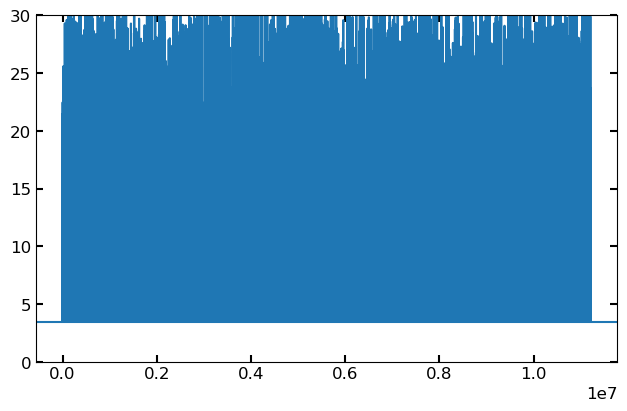

In [7]:
plt.plot(data)
plt.ylim(0,30)
plt.axhline(3.5)

<BarContainer object of 250 artists>

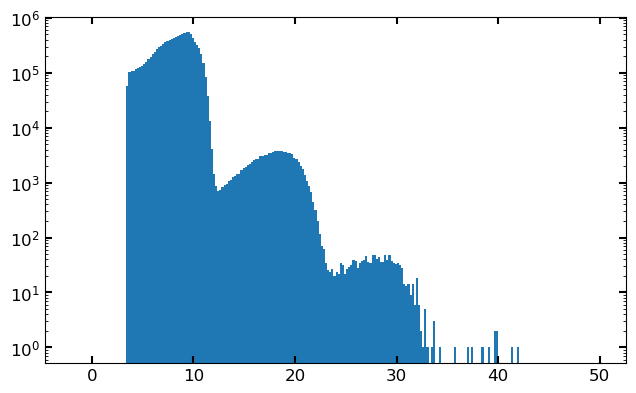

In [8]:
num_bins = 250
hist_range = (-2, 50)  # Adjust this range according to expected pixel values
hist_bins = np.linspace(hist_range[0], hist_range[1], num_bins + 1)
hist_values = np.zeros(num_bins)
hist_values = np.histogram(data, bins=hist_bins)[0]
bin_centers = (hist_bins[:-1] + hist_bins[1:]) / 2
plt.bar(bin_centers, hist_values, align='center', width=hist_bins[1] - hist_bins[0],log=True)

In [9]:
x_edges=np.arange(1,766,1)
y_edges=np.arange(1,702,1)
H,xedges,yedges=np.histogram2d(cols,rows,bins=(x_edges,y_edges))
X,Y=np.meshgrid(xedges,yedges)

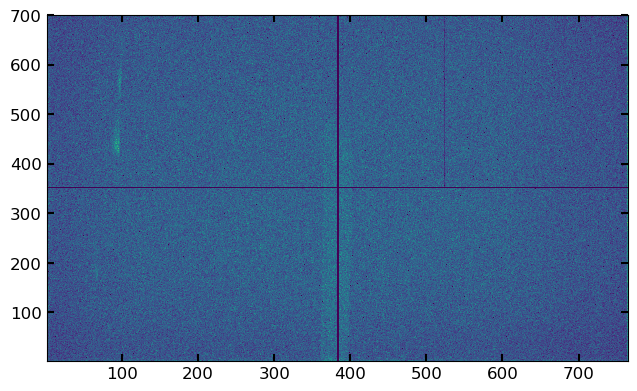

In [10]:
plt.pcolormesh(X,Y,H.T)

/sdf/group/lcls/ds/ana/sw/conda1/inst/envs/ana-4.0.66-py3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/sdf/group/lcls/ds/ana/sw/conda1/inst/envs/ana-4.0.66-py3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/sdf/group/lcls/ds/ana/sw/conda1/inst/envs/ana-4.0.66-py3/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/sdf/group/lcls/ds/ana/sw/conda1/inst/envs/ana-4.0.66-py3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/sdf/group/lcls/ds/ana/sw/conda1/inst/envs/ana-4.0.66-py3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid va

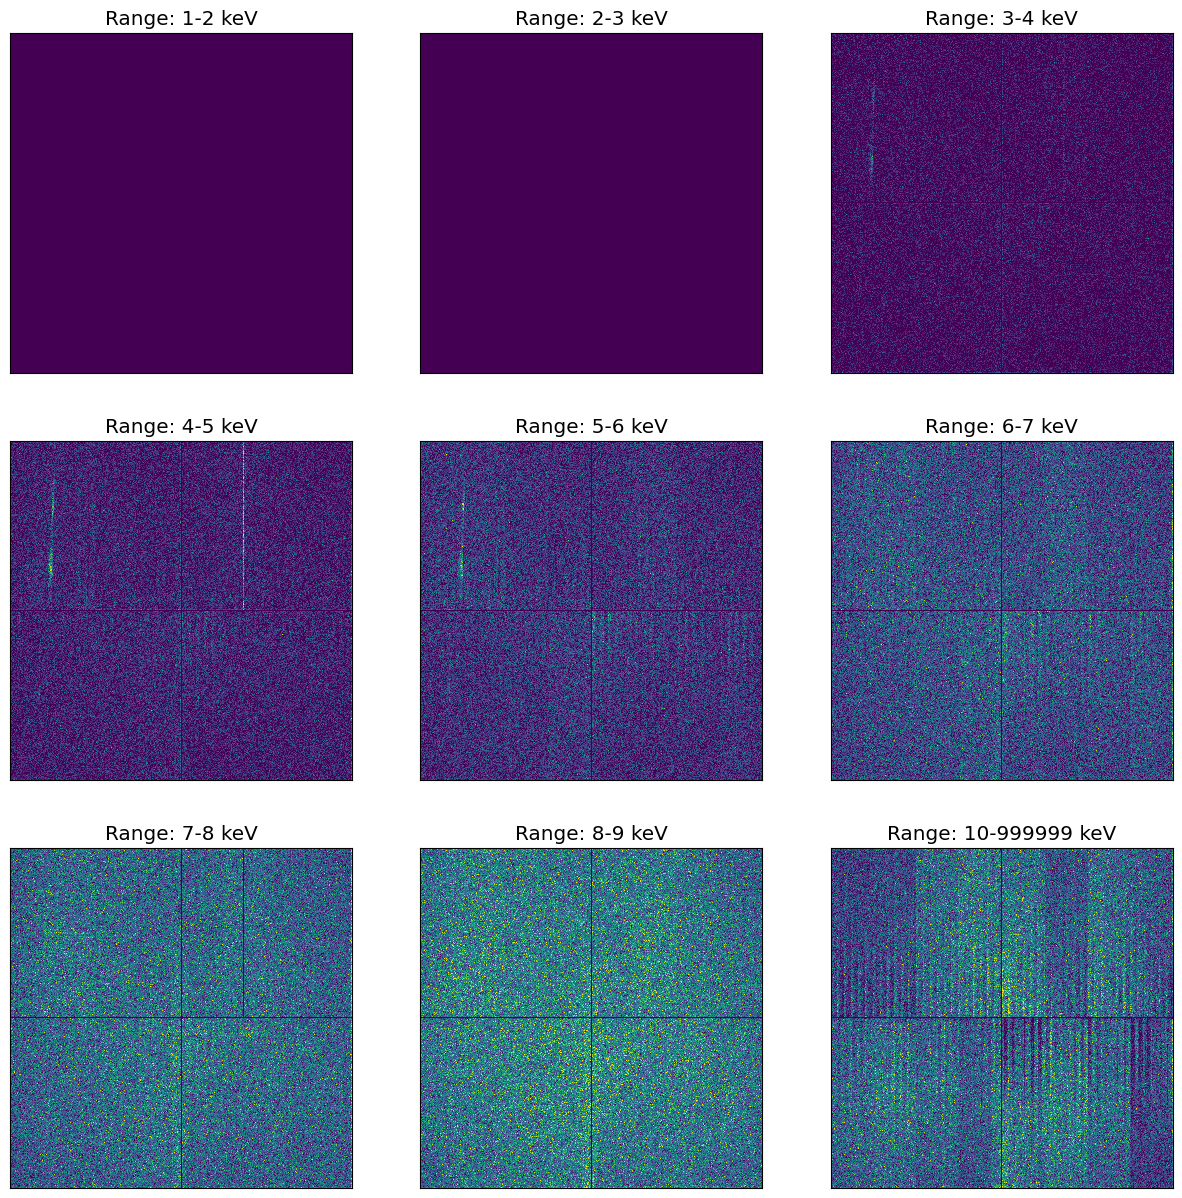

In [11]:
def find_lims(data, f):
    """Return low and high limits based on a factor, ignoring zero values."""
    non_zero_data = data[data != 0]  # Filter out zeros
    x_bar = np.mean(non_zero_data)
    sig_x = np.std(non_zero_data)
    low_lim = x_bar - f * sig_x
    high_lim = x_bar + f * sig_x
    return low_lim, high_lim
import pandas as pd
df=pd.DataFrame()
df['col']=cols
df['row']=rows
df['data']=data

scale = 1
xedges = np.linspace(1, 766, int(766/scale))
yedges = np.linspace(1, 702, int(702/scale))
df_hits=df
data_ranges = [(1,2),(2,3),(3,4), (4,5), (5,6), (6,7), (7,8), (8,9),(10,999999)]
num_cols = 3
num_rows = int(np.ceil(len(data_ranges) / num_cols))  # Ensure proper layout

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

for i, data_range in enumerate(data_ranges):
    subset_filt_data = df_hits[(df_hits['data'] >= data_range[0]) & (df_hits['data'] < data_range[1])]
    H, xedges, yedges = np.histogram2d(subset_filt_data['col'], subset_filt_data['row'], bins=(xedges, yedges))

    X, Y = np.meshgrid(xedges, yedges)
    f = 0.5
    low_lim, upper_lim = find_lims(H, f)
    
    ax = axes[i // num_cols, i % num_cols]  # Select subplot

    im = ax.pcolormesh(X, Y, H.T, vmin=low_lim, vmax=upper_lim)
    im = ax.pcolormesh(X, Y, H.T,vmin=0, vmax=10)

    ax.set_title(f'Range: {data_range[0]}-{data_range[1]} keV')
    ax.set_xticks([])
    ax.set_yticks([])
    # cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    # cbar.set_label("Counts")


In [36]:
run = 238
runs=[237,238,238]
scale = 1
xedges = np.linspace(1, 766, int(766/scale))
yedges = np.linspace(1, 707, int(707/scale))
images=[]
for run in runs:
    d = dt.diagnostics(run, exp, keys, names)    
  
    cols=np.array(d.h5['epix_1/var_droplet_sparse/col'])
    data=np.array(d.h5['epix_1/var_droplet_sparse/data'])
    rows=np.array(d.h5['epix_1/var_droplet_sparse/row'])
    npix=np.array(d.h5['epix_1/var_droplet_sparse/npix'])
    tile=np.array(d.h5['epix_1/var_droplet_sparse/tile'])
    subset_filt_data = df_hits[(df_hits['data'] >= 1) & (df_hits['data'] <  4 )]
    H, xedges, yedges = np.histogram2d(subset_filt_data['col'], subset_filt_data['row'], bins=(xedges, yedges))
    images.append(H)

Run 237 imported
Run 238 imported
Run 238 imported


In [26]:

all_images=np.zeros(np.shape(images[0]))
for image in images:
    all_images+=image

(0.0, 200.0)

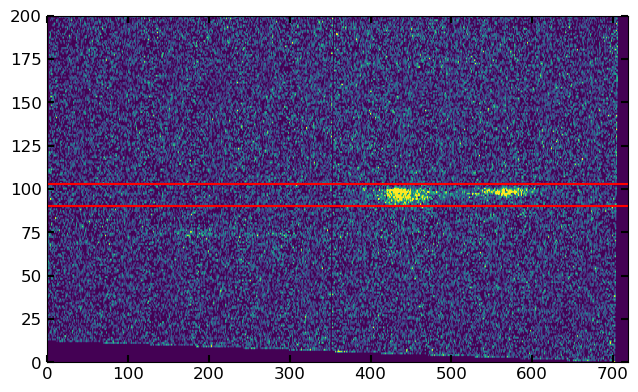

In [27]:
from scipy.ndimage import rotate
vmin, vmax = np.nanpercentile(all_images, [0,99])
plt.imshow(rotate(all_images,1),vmin=vmin,vmax=vmax, origin='lower',aspect='auto')
plt.axhline(90,color='r')
plt.axhline(103,color='r')
plt.ylim(0,200)

In [ ]:
run = 238
runs=[237,238,238]
scale = 1
xedges = np.linspace(1, 766, int(766/scale))
yedges = np.linspace(1, 707, int(707/scale))
images=[]
cutoffs=[3,4,5,6,7,8]
for idx,cutoff in enumearate(cutoffs):
    images=[]
    for run in runs:
        d = dt.diagnostics(run, exp, keys, names)    
      
        cols=np.array(d.h5['epix_1/var_droplet_sparse/col'])
        data=np.array(d.h5['epix_1/var_droplet_sparse/data'])
        rows=np.array(d.h5['epix_1/var_droplet_sparse/row'])
        npix=np.array(d.h5['epix_1/var_droplet_sparse/npix'])
        tile=np.array(d.h5['epix_1/var_droplet_sparse/tile'])
        subset_filt_data = df_hits[(df_hits['data'] >= 2) & (df_hits['data'] <  cutoff )]
        H, xedges, yedges = np.histogram2d(subset_filt_data['col'], subset_filt_data['row'], bins=(xedges, yedges))
        images.append(H)
        
    all_images=np.zeros(np.shape(images[0]))
    for image in images:
        all_images+=image
    ready=np.nansum(rotate(all_images,1)[90:103],axis=0)
    plt.plot(cutoff/10+ready/np.max(ready)-np.mean((ready/np.max(ready))[10:50]))
    plt.legend('Cutoff {}'.format(cutoff))


In [192]:
np.shape(ready)

(719,)

In [ ]:
np.shape(X)

In [29]:
np.shape(Y)

(351, 383)

<BarContainer object of 500 artists>

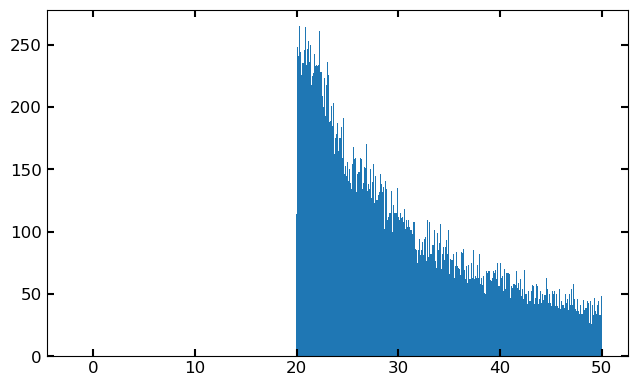

In [29]:
num_bins = 500
hist_range = (-2, 50)  # Adjust this range according to expected pixel values
hist_bins = np.linspace(hist_range[0], hist_range[1], num_bins + 1)
hist_values = np.zeros(num_bins)
hist_values = np.histogram(data, bins=hist_bins)[0]
bin_centers = (hist_bins[:-1] + hist_bins[1:]) / 2
plt.bar(bin_centers, hist_values, align='center', width=hist_bins[1] - hist_bins[0])

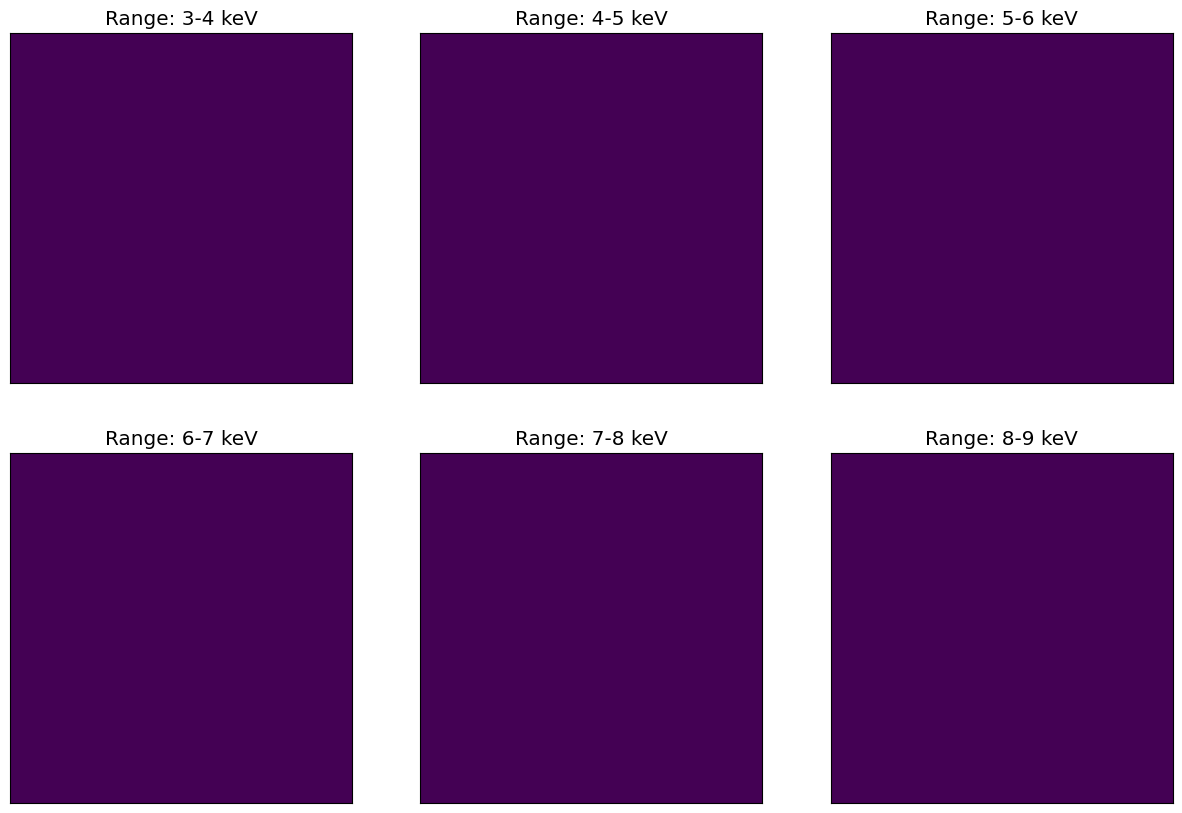

In [30]:
data_ranges = [(3,4), (4,5), (5,6), (6,7), (7,8), (8,9)]
num_cols = 3
num_rows = int(np.ceil(len(data_ranges) / num_cols))  # Ensure proper layout

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

for i, data_range in enumerate(data_ranges):
    subset_filt_data = df_hits[(df_hits['data'] >= data_range[0]) & (df_hits['data'] < data_range[1])]
    H, xedges, yedges = np.histogram2d(subset_filt_data['col'], subset_filt_data['row'], bins=(xedges, yedges))

    X, Y = np.meshgrid(xedges, yedges)
    f = 0.5
    low_lim, upper_lim = find_lims(H, f)
    
    ax = axes[i // num_cols, i % num_cols]  # Select subplot

    # im = ax.pcolormesh(X, Y, H.T, vmin=low_lim, vmax=upper_lim)
    im = ax.pcolormesh(X, Y, H.T, vmin=0, vmax=10)

    ax.set_title(f'Range: {data_range[0]}-{data_range[1]} keV')
    ax.set_xticks([])
    ax.set_yticks([])
    # cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    # cbar.set_label("Counts")

Run 237 imported
Run 238 imported
Run 238 imported
Run 237 imported
Run 238 imported
Run 238 imported
Run 237 imported
Run 238 imported
Run 238 imported
Run 237 imported
Run 238 imported
Run 238 imported
Run 237 imported
Run 238 imported
Run 238 imported
Run 237 imported
Run 238 imported
Run 238 imported
Run 237 imported
Run 238 imported
Run 238 imported
Run 237 imported
Run 238 imported
Run 238 imported
Run 237 imported
Run 238 imported
Run 238 imported
Run 237 imported
Run 238 imported
Run 238 imported
Run 237 imported
Run 238 imported
Run 238 imported
Run 237 imported
Run 238 imported
Run 238 imported
Run 237 imported
Run 238 imported
Run 238 imported
Run 237 imported
Run 238 imported
Run 238 imported
Run 237 imported
Run 238 imported
Run 238 imported
Run 237 imported
Run 238 imported
Run 238 imported
Run 237 imported
Run 238 imported
Run 238 imported
Run 237 imported
Run 238 imported
Run 238 imported
Run 237 imported
Run 238 imported
Run 238 imported
Run 237 imported
Run 238 import

(300.0, 670.0)

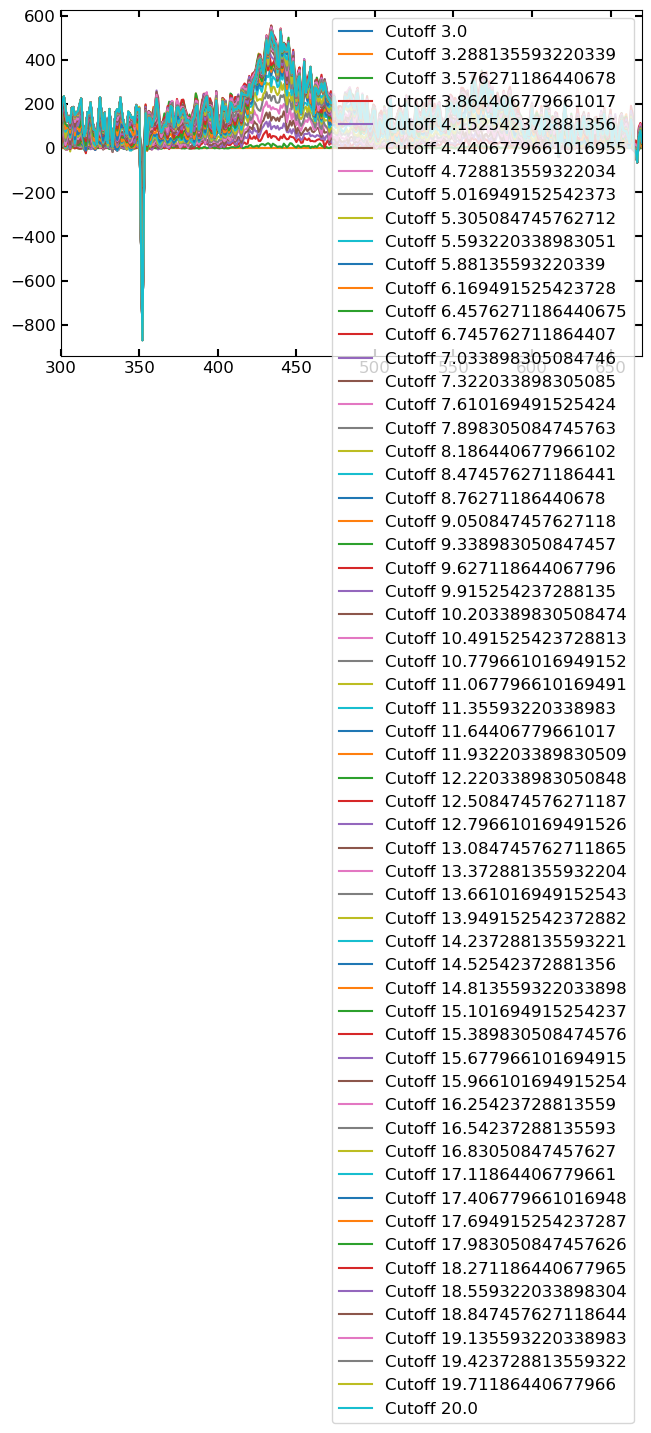

In [65]:
run = 238
runs=[237,238,238]
scale = 1
xedges = np.linspace(1, 766, int(766/scale))
yedges = np.linspace(1, 707, int(707/scale))
images=[]
cutoffs=[3,4,5,6,7,8,9,10,11,12,13,14,15]
cutoffs=np.linspace (3,20,60)
# Create a list to hold the plots' handles
plot_handles = []
sums=[]
stds=[]
for idx,cutoff in enumerate(cutoffs):
    images=[]
    for run in runs:
        d = dt.diagnostics(run, exp, keys, names)    
      
        cols=np.array(d.h5['epix_1/var_droplet_sparse/col'])
        data=np.array(d.h5['epix_1/var_droplet_sparse/data'])
        rows=np.array(d.h5['epix_1/var_droplet_sparse/row'])
        npix=np.array(d.h5['epix_1/var_droplet_sparse/npix'])
        tile=np.array(d.h5['epix_1/var_droplet_sparse/tile'])
        subset_filt_data = df_hits[(df_hits['data'] >= 2) & (df_hits['data'] <  cutoff )]
        H, xedges, yedges = np.histogram2d(subset_filt_data['col'], subset_filt_data['row'], bins=(xedges, yedges))
        images.append(H)
        
    all_images=np.zeros(np.shape(images[0]))
    for image in images:
        all_images+=image
    ready=np.nansum(rotate(all_images,1)[90:103],axis=0)
    #plot_handle, = plt.plot(cutoff / 10 + ready / np.max(ready) - np.mean((ready / np.max(ready))[10:50]))  # Add comma here
    plot_handle, = plt.plot(cutoff / 10 + ready  - np.mean((ready[10:50] )))  # Add comma here
    
    plot_handles.append(plot_handle) # Append the handle to the list
    mean_slice = np.mean(ready[10:50])
    
    # Calculate the sum of the subtraction within a specific slice
    sum_slice = np.nansum(ready[425:450] - mean_slice)
    sums.append(sum_slice)
    
    # Calculate the standard deviation of the subtraction within a specific slice
    std_slice = np.std(ready[425:450] - mean_slice)
    stds.append(std_slice)
plt.legend(plot_handles, ['Cutoff {}'.format(cutoff) for cutoff in cutoffs])  # Use plot_handles to create legend
plt.xlim([300,670])

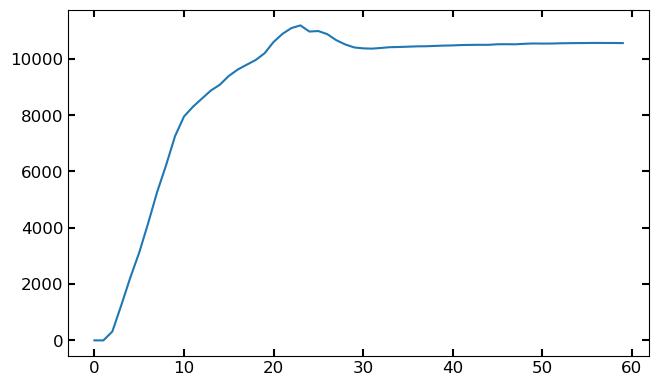

In [69]:
plt.plot(sums)

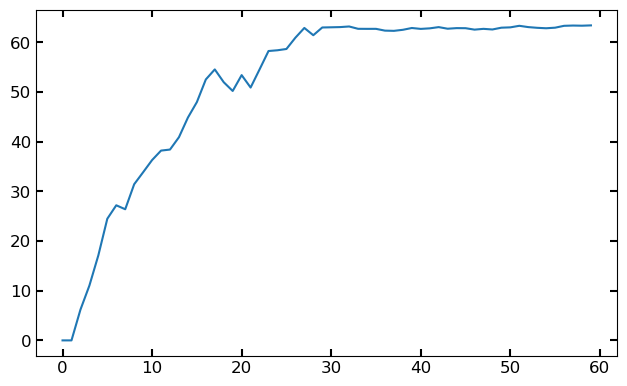

In [70]:
plt.plot(stds)

/lscratch/lbgee/tmp/ipykernel_4049271/3975524215.py:1: RuntimeWarning: invalid value encountered in divide
  plt.plot(np.divide(sums,stds))


Text(0.5, 0, 'Droplet Threshold')

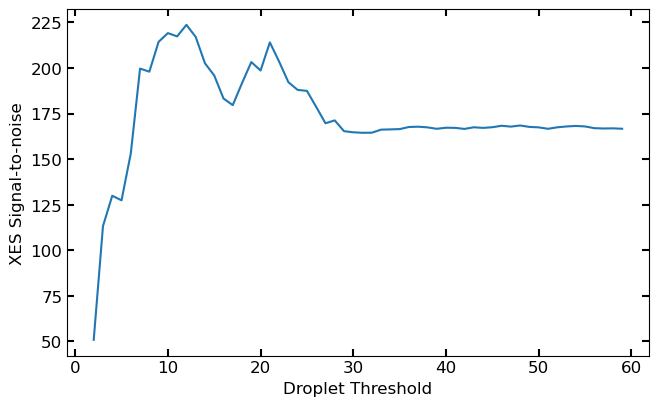

In [71]:
plt.plot(np.divide(sums,stds))
plt.ylabel('XES Signal-to-noise')
plt.xlabel('Droplet Threshold')

In [74]:
images=[]
cutoff=10
for run in runs:
    d = dt.diagnostics(run, exp, keys, names)    
  
    cols=np.array(d.h5['epix_1/var_droplet_sparse/col'])
    data=np.array(d.h5['epix_1/var_droplet_sparse/data'])
    rows=np.array(d.h5['epix_1/var_droplet_sparse/row'])
    npix=np.array(d.h5['epix_1/var_droplet_sparse/npix'])
    tile=np.array(d.h5['epix_1/var_droplet_sparse/tile'])
    subset_filt_data = df_hits[(df_hits['data'] >= 2) & (df_hits['data'] <  cutoff )]
    H, xedges, yedges = np.histogram2d(subset_filt_data['col'], subset_filt_data['row'], bins=(xedges, yedges))
    images.append(H)
    
all_images=np.zeros(np.shape(images[0]))
for image in images:
    all_images+=image
ready=np.nansum(rotate(all_images,1)[90:103],axis=0)

Run 237 imported
Run 238 imported
Run 238 imported


In [75]:
np.savetxt('droplets.npy',ready)

In [ ]:
d.h5.keys()

In [ ]:
d.h5['epix_2'].keys()

In [ ]:
d.h5['Sums'].keys()

In [ ]:
d.h5['gas_detector'].keys()

In [ ]:
# for i in ['11','12','21','22','63','64']:
for i in ['11','12','21','22']:
    plt.plot(d.h5['gas_detector']['f_'+i+'_ENRC'][:],label=i)
plt.legend()

In [ ]:
x_ev=d.h5['scan']['mcc'][:]
fee_spec=d.h5['feeBld']['hproj'][:]
gas_det_22=d.h5['gas_detector']['f_22_ENRC'][:]

In [ ]:
spec_unique=[]
for i in np.unique(x_ev):
    index=np.nonzero(x_ev==i)[0]
    temp=np.nansum(fee_spec[index],0)
    spec_unique.append(temp)
    plt.plot(temp,label='%.1f eV'%i)
spec_unique=np.array(spec_unique)
plt.legend()

plt.figure()
plt.plot(np.nansum(fee_spec,0))

In [ ]:
spec_unique_n=[]
for i in np.unique(x_ev):
    index=np.nonzero(x_ev==i)[0]
    temp=np.nansum(fee_spec[index],0)
    i0_temp=np.nansum(gas_det_22[index],0)
    spec_unique_n.append(temp/i0_temp)
    plt.plot(temp/i0_temp,label='%.1f eV'%i)
spec_unique_n=np.array(spec_unique_n)
plt.legend()

plt.figure()
plt.plot(np.nansum(fee_spec,0)/np.nansum(gas_det_22,0))

In [ ]:
spec_unique_n=[]
for i in np.unique(x_ev):
    index=np.nonzero(x_ev==i)[0]
    temp=np.nansum(fee_spec[index],0)
    i0_temp=np.nansum(gas_det_22[index],0)
    spec_unique_n.append(temp/i0_temp)
    plt.plot(temp/i0_temp,label='%.1f eV'%i)
spec_unique_n=np.array(spec_unique_n)
plt.legend()

plt.figure()
plt.plot(np.nansum(fee_spec,0)/np.nansum(gas_det_22,0))

In [ ]:
d.h5['feeBld']['hproj'][:].shape

In [ ]:
d.h5['feeBld'].keys()
#d.h5['UserDataCfg']['epix_2']['ROI_0__ROI_0_ROI'][:]

In [ ]:
plt.imshow(fee_spec,aspect='auto')

In [ ]:
meanfee = np.nanmean(fee_spec,axis=0)
plt.plot(meanfee)

In [ ]:
d.h5['epix_2'].keys()

In [ ]:
plt.imshow(d.h5['Sums']['epix_1_calib'][:],aspect='auto') #run 13

In [ ]:
plt.imshow(d.h5['Sums']['epix_1_calib'][:],aspect='auto')

In [ ]:
plt.imshow(d.h5['Sums']['epix_2_calib'][:],aspect='auto') #run 13

In [ ]:
#epix_2d = np.nanmean(d.h5['epix_1']['ROI_0_area'][:],axis=0)
plt.imshow(d.h5['Sums']['epix_2_calib'][:],aspect='auto')

In [ ]:
epix_2d = np.nanmean(d.h5['epix_1']['ROI_0_area'][:],axis=0) # run 13
plt.imshow(epix_2d,aspect='auto')

In [ ]:
epix_2d = np.nanmean(d.h5['epix_1']['ROI_0_area'][:],axis=0)
plt.imshow(epix_2d,aspect='auto')

In [ ]:
epix_2d = np.nanmean(d.h5['epix_2']['ROI_0_area'][:],axis=0)
plt.imshow(epix_2d,aspect='auto')

In [ ]:
epix_2d = np.nanmean(d.h5['epix_2']['ROI_0_area'][:],axis=0) # run 13
plt.imshow(epix_2d,aspect='auto')

In [ ]:
plt.plot(np.nanmean(d.h5['epix_1']['ROI_0_spectrum_projection_data'][:],axis=0))
plt.figure()
plt.plot(np.nanmean(d.h5['epix_1']['ROI_0_spatial_projection_data'][:],axis=0))

In [ ]:
plt.plot(np.nanmean(d.h5['epix_1']['ROI_0_spectrum_projection_data'][:],axis=0))
plt.figure()
plt.plot(np.nanmean(d.h5['epix_1']['ROI_0_spatial_projection_data'][:],axis=0))

In [ ]:
d.datadict

In [ ]:
nshots = 1000
thresholds = [3]

d.adu_histogram(nshots, thresholds)

In [ ]:
ipm_thres = [10000]

d.ipm_histogram(ipm_thres)

In [ ]:
#tt_thres = [0.01, 0.1]

#d.ttAMPL_histogram(tt_thres)

In [ ]:
nshots = 1000
# ka_roi = [120, 140]
kb_roi = [100, 400]
#fe_kb_roi = [40,60]

d.xes_ROI(nshots, kb_limits = kb_roi)


In [ ]:
#nshots = 1000
# ka_roi = [120, 140]
#kb_roi = [140, 155]
#fe_kb_roi = [40,60]

#d.xes_ROI(nshots, kb_limits = kb_roi)


In [ ]:
#nshots = 1000
#h_lims = [40, 160]
#v_lims = [150, 400]
nshots = 1000
h_lims = [0, 200]
v_lims = [0, 705]
d.xas_ROI(nshots, horiz_limits = h_lims, vert_limits = v_lims)